# Tweets sentiments Classification

### Import libries

In [ ]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss, f1_score, recall_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import GridSearchCV

# 1- Loading Data

In [ ]:
df_train = pd.read_csv('train.csv')

In [ ]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27481,27480,27480,27481
unique,27481,27480,22463,3
top,cb44a5ab52,"eating nothing, drinking water, about to watch...",good,neutral
freq,1,1,199,11118


# 2- Cleaning Data

#### Dropping null values

In [ ]:
df_train.isnull().sum()

textID           0
text             1
selected_text    1
sentiment        0
dtype: int64

In [ ]:
df_train.dropna(inplace = True)

In [ ]:
df_train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

In [ ]:
df_train['sentiment'].value_counts()

neutral     11117
positive     8582
negative     7781
Name: sentiment, dtype: int64

Dataset Analysis:



*   there are 27480 samples
*   The dataset contains 3 diffrent classess natural, positive, and negative
*   There was a null value in the 'selected_text' coulmn.
*   Neutral classs has 







# 3- Preproceseing Data

### Removeing Stop words and Punctuation

In [ ]:
text = df_train['text']
punctuation = '"#$%&()+,-./:;<=>@[\]^_`{|}~'

def text_cleaning(data):
    sw_file = open("stopwords.txt", "r")
    content = sw_file.read()
    stopwords = content.split("\n")
    
    remove_punc = [i for i in data if i  not in punctuation]
    remove_punc = ''.join(remove_punc)
    
    remove_stopwords = [i for i in remove_punc.split() if i.lower() not in stopwords]
    processed = ' '.join(remove_stopwords)
    
    return processed



In [ ]:
df_train['clean_text'] = df_train.text.apply(text_cleaning)


In [ ]:
df_train.head()

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,Id responded going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,Sooo SAD miss San Diego!!!
2,088c60f138,my boss is bullying me...,bullying me,negative,boss bullying
3,9642c003ef,what interview! leave me alone,leave me alone,negative,interview! leave alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,Sons **** couldnt put releases already bought


Represent classess with a numirical values

In [ ]:

lbl_enc = preprocessing.LabelEncoder()
y = lbl_enc.fit_transform(df_train.sentiment.values)
print(y)

[1 0 0 ... 2 2 1]


Extract the features from the text and represent it numerically

In [ ]:

X = df_train.clean_text.values
tfv = TfidfVectorizer(min_df=3,  max_features=None, 
            strip_accents='unicode', analyzer='word',token_pattern=r'\w{1,}',
            ngram_range=(1, 3), use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english')

tfv.fit(list(X))
X =  tfv.transform(X) 


Splitting Data

In [ ]:
trainx, valx, trainy, valy = train_test_split(X,y,test_size=0.30,random_state=777)
testx, valx, testy, valy = train_test_split(valx,valy,test_size=0.50,random_state=777)

print('trainx shape:',trainx.shape)
print('trainy shape:',trainy.shape)
print('valx shape:',valx.shape)
print('valy shape:',valy.shape)
print('testx shape:',testx.shape)
print('testy shape:',testy.shape)

trainx shape: (16340, 11315)
trainy shape: (16340,)
valx shape: (3502, 11315)
valy shape: (3502,)
testx shape: (3501, 11315)
testy shape: (3501,)


###Balancing data

In [ ]:
# dropp = trainx.drop(df_train[df_train['sentiment'] == 'neutral'].sample(frac=0.30).index)
# df_train = dropp.drop(df_train[df_train['sentiment'] == 'positive'].sample(frac=0.0931).index)


In [ ]:
from imblearn.under_sampling import NearMiss
from collections import Counter

undersample = NearMiss(version=1, n_neighbors=3)
# transform the dataset
trainx, trainy = undersample.fit_resample(trainx, trainy)
counter = Counter(trainy)
print(counter)

Counter({0: 5420, 1: 5420, 2: 5420})


### Correlation analysis

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


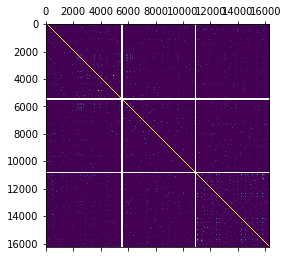

In [ ]:
Correlation  = np.corrcoef(trainx.toarray())
plt.matshow(Correlation)
plt.show()

We can not conclude any relation from the correlation graph, probably because of the high dimensionality of the training data

## Evaluation measures
#### We have selected Log loss, F1 score, Recall and confusion matrix to muesure out models for the following reasosn:
* Log loss takes into account the uncertainty of your prediction based on how much it varies from the actual label.
* F1 is sensitive to any small change in precision or recalland that will result in lower overall score.
* Recall gives a measure of how accurately our model is able to identify the relevant data.
* confusion matrix gives information about errors made by the classifier and the types of errors that are being made.

## List of Chosen classifiers
#### We have selected Logistic Regression, Decision Tree, and KNN Classifier for the following reasons:

* They do not require normalization of data
* Compared to other algorithms They require less computational cost and time except for KNN.
*  They make no assumptions about distributions of classes in feature space except for KNN.
* They can easily extend to multiple classes problems and give an excellent performance except for KNN.


LogisticRegression with Bagging 

In [ ]:
bag_logistic = BaggingClassifier(LogisticRegression(C=1.0,max_iter = 10000))
bag_logistic.fit(trainx, trainy)
logistic_pred = bag_logistic.predict_proba(valx)
print('log_loss accuracy :' ,log_loss(valy, logistic_pred))



log_loss accuracy : 0.7665136692330904


KNeighborsClassifier

In [ ]:
accuracy_bf = []
cpu_bf = []
for i in range(1,20,2):
    knn_bf = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
    knn_bf.fit(trainx,trainy)
    predict_bf = knn_bf.score(valx,valy)
    accuracy_bf.append(predict_bf)
    


# classifier= KNeighborsClassifier(n_neighbors=3, p=2 , algorithm="auto")
# classifier.fit(trainx, trainy)
# knn_pred= classifier.predict(valx)
# print("Accuracy score :",accuracy_score(valy, knn_pred))
# print("Recall score :", recall_score(valy, knn_pred,average='micro'))
# print("f1 score :", f1_score(valy, knn_pred, average='micro'))
# print("confusion matrix :\n", confusion_matrix(valy, knn_pred))
# print("classification_report", classification_report(valy, knn_pred))

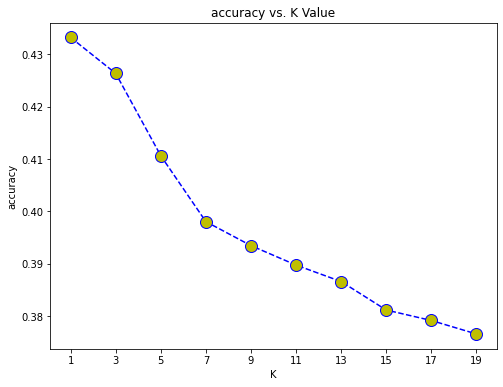

In [ ]:
plt.figure(figsize=(8,6))
plt.plot(range(1,20,2),accuracy_bf , color='blue', linestyle='dashed', marker='o',
         markerfacecolor='y', markersize=12)
plt.title('accuracy vs. K Value')
plt.xlabel('K')
plt.ylabel('accuracy')
#plt.ylim([0,1])
plt.xticks(np.arange(1, 20, 2))
plt.show()

From the graph we can see that 1nn gives the best result among other k's

DecisionTreeClassifier

In [ ]:
from sklearn.ensemble import BaggingClassifier
# training and hyper-parameter tuning
param_grid = {
    'base_estimator__max_depth' : np.arange(1,10),
    'max_samples' : [0.1, 0.9, 0.5],'n_estimators' : [100,150,200,250,300]
}

grid_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(),
                                     max_features = 0.5,random_state = 7),
                                     param_grid)
grid_bag.fit(trainx, trainy)

GridSearchCV(estimator=BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                         max_features=0.5, random_state=7),
             param_grid={'base_estimator__max_depth': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'max_samples': [0.1, 0.9, 0.5],
                         'n_estimators': [100, 150, 200, 250, 300]})

In [ ]:
print("Best hyper-parameters",grid_bag.best_params_)
print("Best accuracy :",grid_bag.best_score_)

Best hyper-parameters {'base_estimator__max_depth': 9, 'max_samples': 0.1, 'n_estimators': 250}
Best accuracy : 0.5785362853628536


In [ ]:
dtree = BaggingClassifier(base_estimator = DecisionTreeClassifier(),n_estimators = 300,random_state = 7)

dtree = dtree.fit(trainx,trainy)

dtree_pred = dtree.predict(valx)


print("Accuracy score :",accuracy_score(valy, dtree_pred))
print("Recall score :", recall_score(valy, dtree_pred,average='micro'))
print("f1 score :", f1_score(valy, dtree_pred, average='micro'))
print("confusion matrix :\n", confusion_matrix(valy, dtree_pred))
print("classification_report", classification_report(valy, dtree_pred))

Accuracy score : 0.6933181039406053
Recall score : 0.6933181039406053
f1 score : 0.6933181039406053
confusion matrix :
 [[752 295 105]
 [207 791 193]
 [ 74 200 885]]
classification_report               precision    recall  f1-score   support

           0       0.73      0.65      0.69      1152
           1       0.62      0.66      0.64      1191
           2       0.75      0.76      0.76      1159

    accuracy                           0.69      3502
   macro avg       0.70      0.69      0.69      3502
weighted avg       0.70      0.69      0.69      3502



##  Conclusions from the work

#### Error analysis and possible improvements 
* We could have improved our models by doing proper hyperparameters tuning, but we are dealing with a large dataset our hyperparameter tuning process took +500 minutes and didn't converge.
* exploring different boosting methods.
* Extracting the features with different methods like word embedding and countVectorizer.

#### Problems we faced
* having an  imbalanced dataset, and we dealt with it by making all the classes equal, and that improved our models accuracy by 3%
* using the right method to convert the text into an index, and we managed to solve that by using TfidfVectorizer.
* Finding the right models for our problems, and we managed to solve that by trying various models like linear regression and SVM until we found the best 3 models in case of the computation cost and efficiency 
* dealing with text dataset.
